In [1]:
import pandas as pd
import numpy as np
import pyperclip as pc

# ___________________________________________________________________
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection as ms
from sklearn import datasets, svm, metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
import sklearn.datasets as datasets
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# ____________________________________________________________________
from scipy import stats
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import chart_studio.plotly as py
import cufflinks as cf
import datetime as dt

#_____________________________________________________________________
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

from joblib import Parallel, delayed
import multiprocessing
from IPython.display import display, clear_output
import plotly.tools as tls
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import json

#___________________________________________________________________
import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)
cf.go_offline()

# tls.set_credentials_file(username='marcelofprado', api_key='cftsFWfYZ7DgpGQtDuRe')
# init_notebook_mode(connected=True)

np.seterr(divide='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [2]:
resp = pd.read_csv('respirators_brazil.csv')
resp_sum = resp['equipments'].sum()

In [3]:
italy_data = pd.read_csv('20200324_covid_data_italy.csv')
# print(italy_data)
italy_data['date'] = pd.to_datetime(italy_data['data'], format='%Y-%m-%d %H:%M:%S').dt.date
italy_data = italy_data[['date','totale_casi', 'deceduti','ricoverati_con_sintomi', 'totale_ospedalizzati', 'totale_attualmente_positivi']]
italy_data.columns = ['date','cases','deaths', 'recovered', 'hospitalized', 'active_cases']
italy_data = italy_data.set_index('date', drop=True)
italy_data

,cases,deaths,recovered,hospitalized,active_cases
date,,,,,
2020-02-24,229,7,101,127,221
2020-02-25,322,10,114,150,311
2020-02-26,400,12,128,164,385
2020-02-27,650,17,248,304,588
2020-02-28,888,21,345,409,821
2020-02-29,1128,29,401,506,1049
2020-03-01,1694,34,639,779,1577
2020-03-02,2036,52,742,908,1835
2020-03-03,2502,79,1034,1263,2263


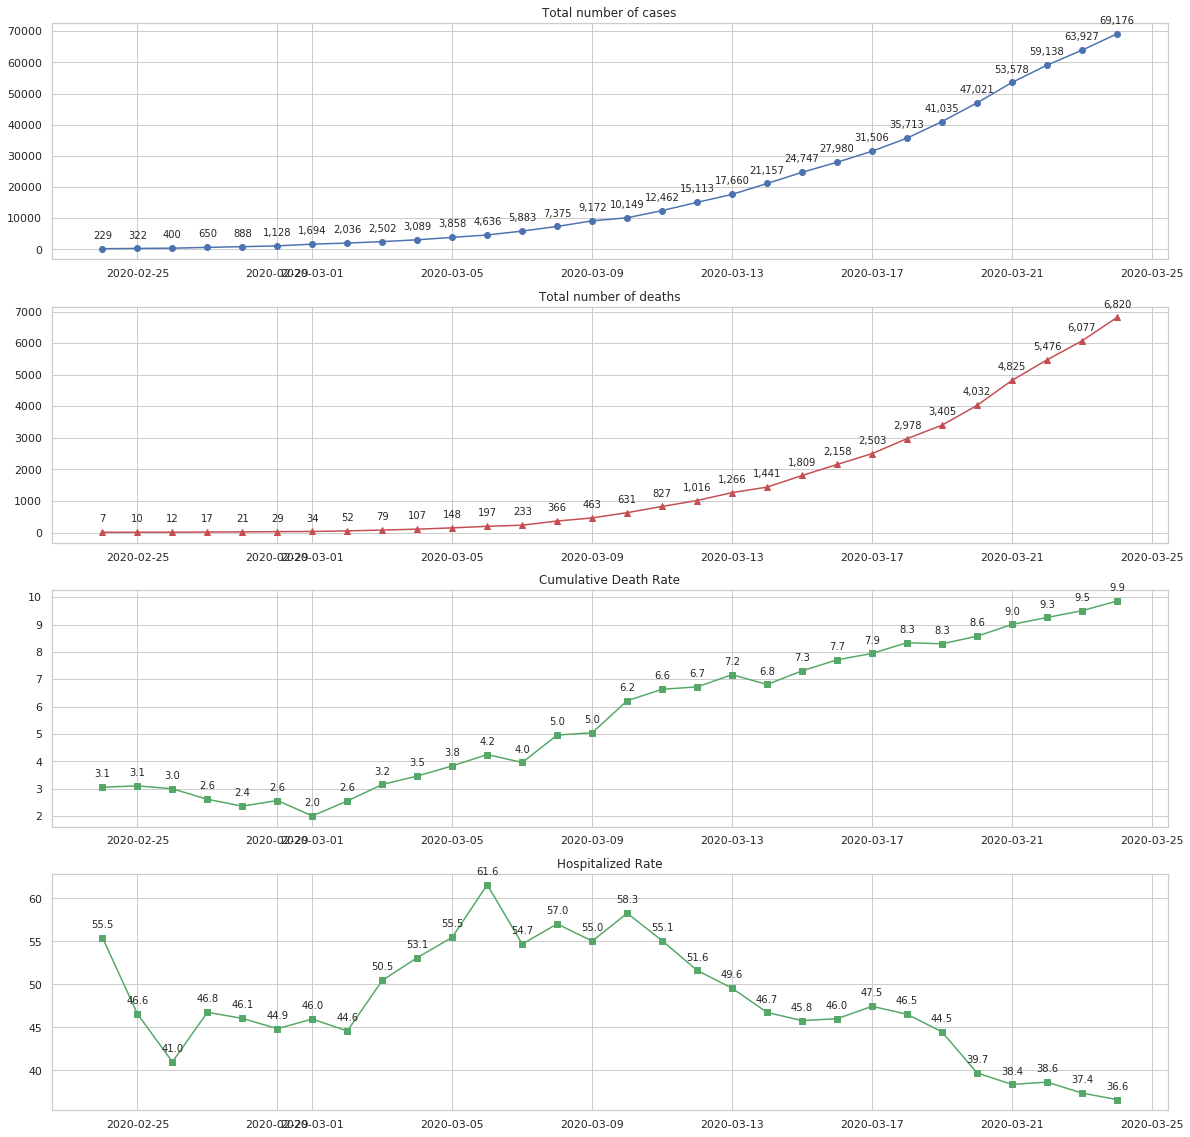

In [4]:
plt.figure(figsize = (20,20))

# plt.gca().title('Italian Cases')

plt.subplot('411')
xs = italy_data.index.values
ys = italy_data['cases']
plt.gca().set_title('Total number of cases')
plt.plot(xs, ys, 'bo-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('412')
plt.gca().set_title('Total number of deaths')
ys = italy_data['deaths']
plt.plot(xs, ys, 'r^-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('413')
plt.gca().set_title('Cumulative Death Rate')
ys = italy_data['deaths'] / italy_data['cases'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.subplot('414')
plt.gca().set_title('Hospitalized Rate')
ys = italy_data['hospitalized'] / italy_data['cases'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.savefig('italian_overview')
plt.show()

In [5]:
data = np.array([
    [dt.datetime(2020,2,25) + dt.timedelta(days=i) for i in range(0,29)],
    [1,1,1,1,2,2,2,2,3,8,13,19,25,25,34,52,77,151,151,200,234,346,529,640,970,1178, 1546, 1924,2247],
    [1,1,1,1,2,2,2,2,3,8,13,19,25,25,34,52,77,150,150,198,232,343,523,631,957,1158, 1519,1888,2199],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,7,11,18,25,34,46],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0]]
).transpose()
cols = ['date','cases', 'active_cases', 'deaths', 'recovered']

brazil_data = pd.DataFrame(data, columns = cols)
brazil_data['date'] = brazil_data['date'].dt.date
brazil_data = brazil_data.set_index('date', drop=True)
brazil_data['resp_aux'] = (brazil_data.index >= (dt.datetime.strptime('2020-03-23','%Y-%m-%d')).date()) * (350 / 7)
brazil_data['resp_aux'] = brazil_data['resp_aux'].cumsum()
brazil_data['respirator'] = brazil_data['resp_aux'] + resp_sum
brazil_data.to_csv('covid_data_brazil.csv')

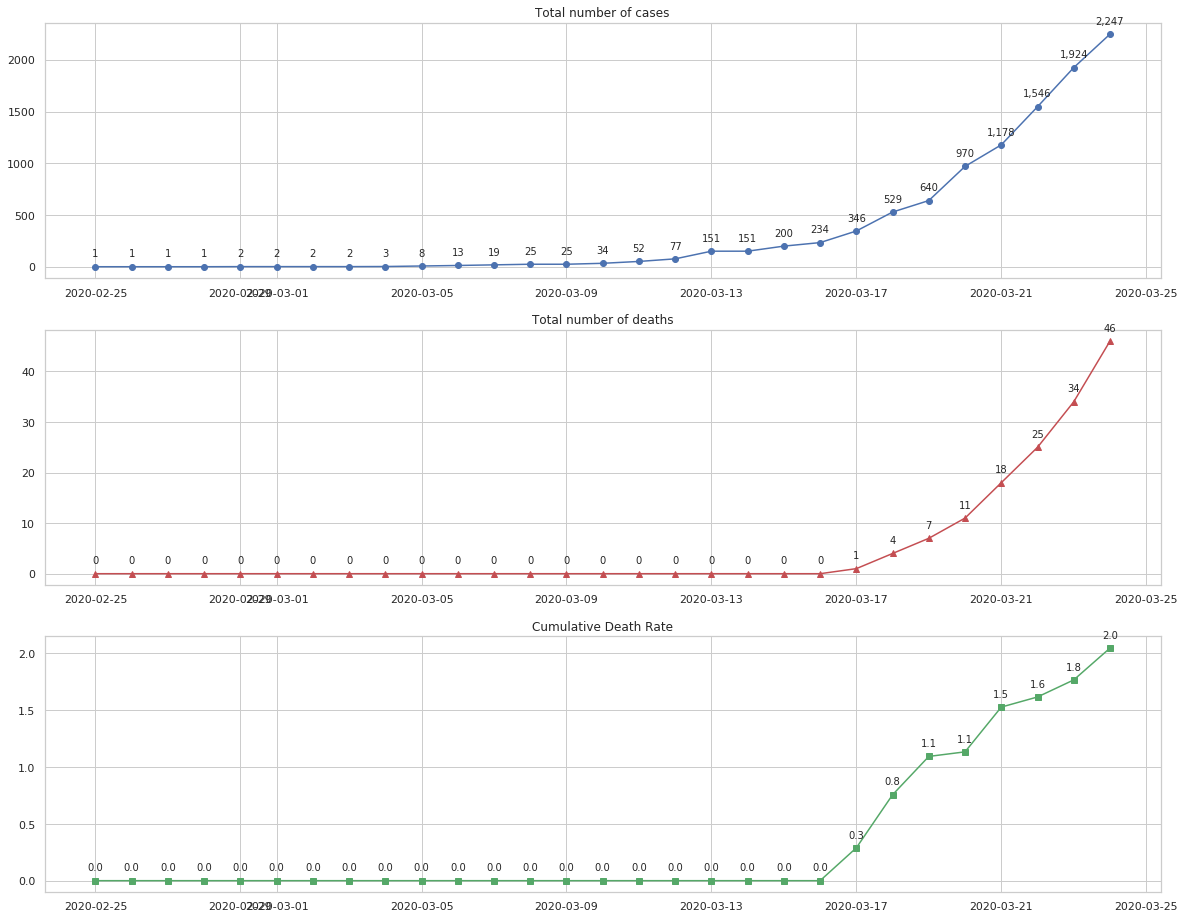

In [6]:
plt.figure(figsize = (20,16))

# plt.gca().title('Italian Cases')

plt.subplot('311')
xs = brazil_data.index.values
ys = brazil_data['cases']
plt.gca().set_title('Total number of cases')
plt.plot(xs, ys, 'bo-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('312')
plt.gca().set_title('Total number of deaths')
ys = brazil_data['deaths']
plt.plot(xs, ys, 'r^-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('313')
plt.gca().set_title('Cumulative Death Rate')
ys = brazil_data['deaths'] / brazil_data['cases'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.savefig('brazil_overview')
plt.show()

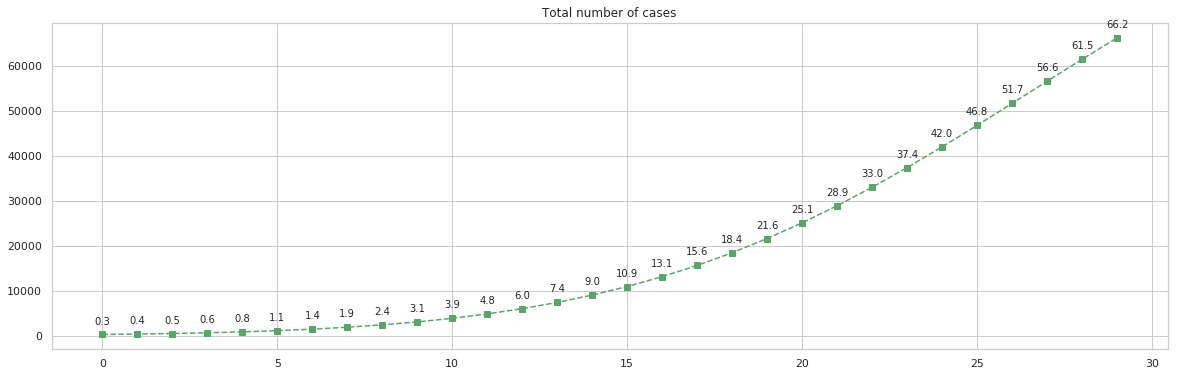

In [19]:
br_data = brazil_data[20:].reset_index()
ys = ((italy_data['cases'].append(br_data['cases'])).astype(float)).values
xs = [i for i in range (0,len(italy_data['cases']))] +  [i for i in range (0,len(br_data['cases']))]
p = np.poly1d(np.polyfit(xs, np.log(ys), 2))

xse = [i for i in range (0,len(italy_data['cases']))]
yse = p(xse)

plt.figure(figsize = (20,6))

# plt.subplot('211')
# plt.gca().set_title('Total number of cases')
# plt.plot(xs, ys, 'bo-')
# for x,y in zip(xs,ys):
#     label = "{:,.1f}".format(y / 1000)
#     plt.annotate(label, # this is the text
#                  (x,y), # this is the point to label
#                  textcoords="offset points", # how to position the text
#                  xytext=(0,10), # distance from text to points (x,y)
#                  ha='center') # horizontal alignment can be left, right or center
    
# plt.subplot('212')
plt.gca().set_title('Total number of cases')
plt.plot(xse, np.exp(yse), 'gs--')
for x,y in zip(xs,np.exp(yse)):
    label = "{:,.1f}".format(y / 1000)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

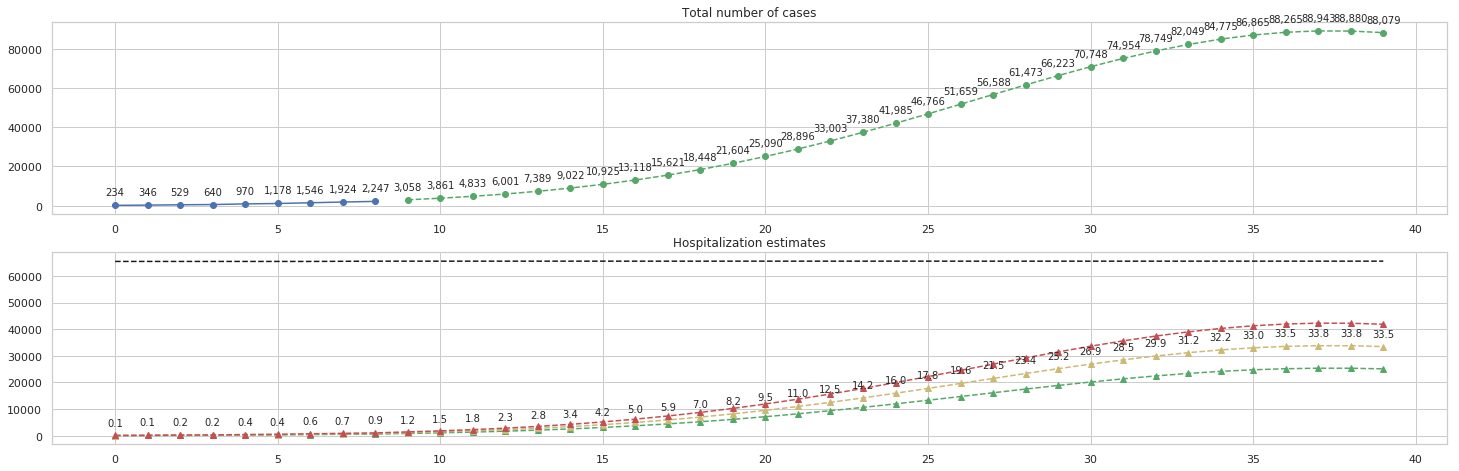

In [20]:
plt.figure(figsize = (25,12))

# plt.gca().title('Italian Cases')
n = 40
xs = range(0,n)
yse = p(range(len(br_data), n))
zs = (br_data['cases'].append(pd.Series(np.exp(yse)))).reset_index(drop = True)
ys = (br_data['cases'].append(pd.Series(np.nan for i in range(0,len(yse))))).reset_index(drop=True)
yse = (pd.Series(np.nan for i in range(0,len(br_data))).append(pd.Series(p(range(len(br_data), n))))).reset_index(drop=True)

plt.subplot('311')
plt.gca().set_title('Total number of cases')
plt.plot(xs, ys, 'bo-', np.exp(yse), 'go--')
for x,y in zip(xs,zs):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.subplot('312')
plt.gca().set_title('Hospitalization estimates')
est1 = zs * 0.3 - zs * 0.015
est2 = zs * 0.4 - zs * 0.02
est3 = zs * 0.5 - zs * 0.025
rep_max = br_data['respirator'].max()
resp_line = br_data['respirator'].copy()
resp_line = ((resp_line.append(pd.Series(rep_max for i in range(0,len(p(range(len(br_data), n))))))).reset_index(drop=True)).values
plt.plot(xs, est1, 'g^--', est2, 'y^--', est3, 'r^--', resp_line, 'k--')
# for x,y in zip(xs,est1):
#     label = "{:,.1f}".format(y / 1000)
#     plt.annotate(label, # this is the text
#                  (x,y), # this is the point to label
#                  textcoords="offset points", # how to position the text
#                  xytext=(0,10), # distance from text to points (x,y)
#                  ha='center') # horizontal alignment can be left, right or center
    
for x,y in zip(xs,est2):
    label = "{:,.1f}".format(y / 1000)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
# for x,y in zip(xs,est3):
#     label = "{:,.1f}".format(y / 1000)
#     plt.annotate(label, # this is the text
#                  (x,y), # this is the point to label
#                  textcoords="offset points", # how to position the text
#                  xytext=(0,10), # distance from text to points (x,y)
#                  ha='center') # horizontal alignment can be left, right or center
    
plt.savefig('brazil_forecast')
plt.show()
# resp_line

In [15]:
data = np.array([
    [dt.datetime(2020,2,16) + dt.timedelta(days=i) for i in range(0,38)],
    [15,15,15,15,15,15,35,35,35,53,57,60,63,68,75,100,124,158,221,319,435,541,704,994,1301,1697,2247,2943,3680,4663,6411,9259,13789,19383,26111,32356,42443,53287],
    [15,15,15,15,15,15,35,35,35,51,54,54,57,60,65,85,106,138,200,289,401,504,663,949,1248,1625,2157,2830,3553,4503,6196,9003,13474,18980,23729,31764,41361,5228],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,6,9,11,12,15,19,22,26,30,38,41,49,57,68,86,109,150,207,256,324,414,517,689]]
).transpose()
cols = ['date','cases', 'active_cases', 'deaths']

us_data = pd.DataFrame(data, columns = cols)
us_data['recovered'] = us_data['cases'] - us_data['active_cases'] - us_data['deaths']
us_data = us_data.set_index('date', drop = True)
# print(us_data)

us_test = pd.read_csv('20200322_us_testing.csv').fillna(0)
us_test['date'] = pd.to_datetime(us_test['Date Collected'])
us_test['daily_tests'] = us_test['CDC Labs'] + us_test['US Public Health Labs']
us_test['tests'] = us_test['daily_tests'].cumsum()
us_test = us_test.drop(['Date Collected', 'CDC Labs', 'US Public Health Labs'], axis = 1)
us_test = us_test.set_index('date', drop = True)
# us_data = us_data.merge(us_test, on='date')

us_covid = pd.read_csv('us-daily.csv')
us_covid['date'] = pd.to_datetime(us_covid['date'], format='%Y%m%d')
us_covid = us_covid.set_index('date', drop = True)
us_data = us_data.merge(us_covid['total'], on='date')
# us_data['tests'] = us_data[['tests','total']].max(axis = 1)
us_data['tests'] = us_data['total']
us_data = us_data.drop('total', axis = 1)
# us_covid

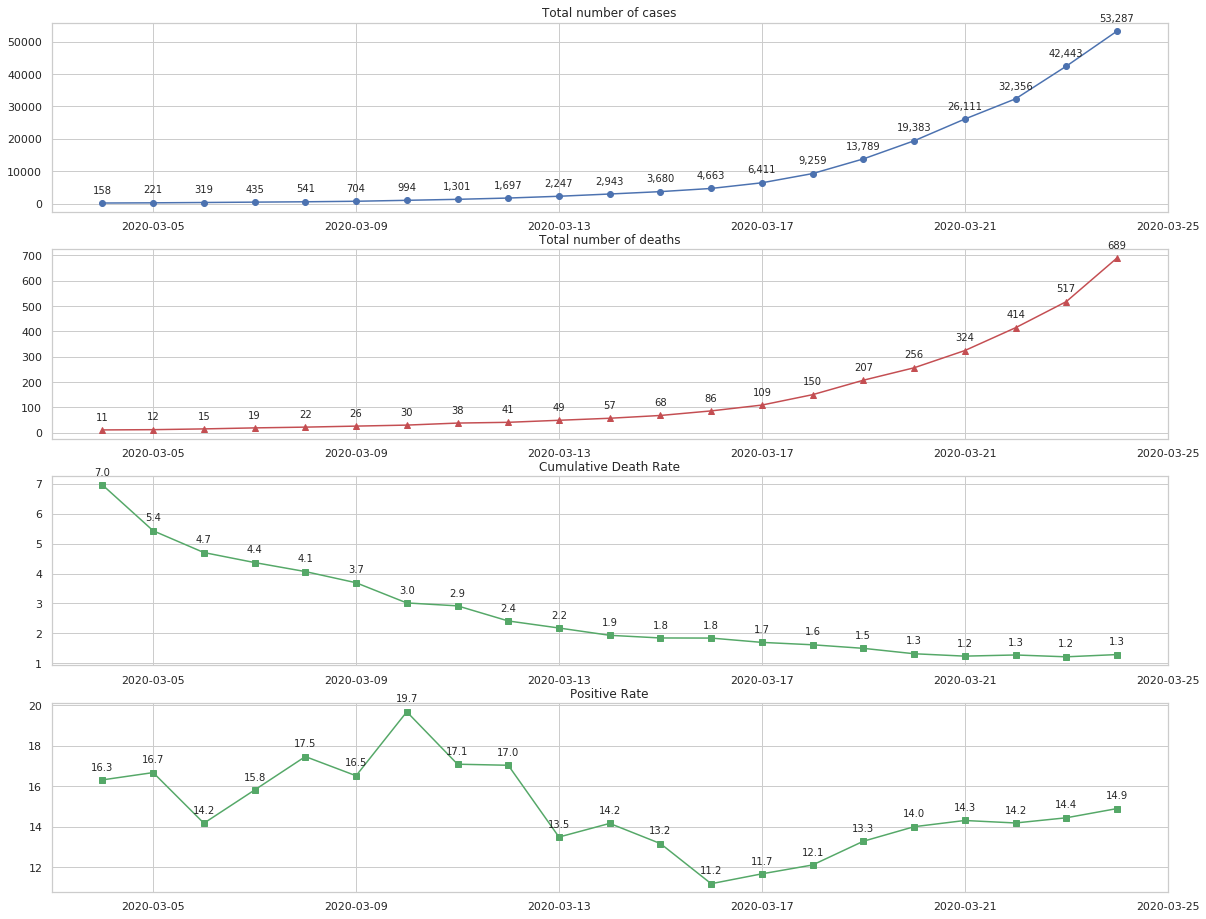

In [16]:
plt.figure(figsize = (20,16))

# plt.gca().title('Italian Cases')

plt.subplot('411')
xs = us_data.index.values
ys = us_data['cases']
plt.gca().set_title('Total number of cases')
plt.plot(xs, ys, 'bo-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('412')
plt.gca().set_title('Total number of deaths')
ys = us_data['deaths']
plt.plot(xs, ys, 'r^-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('413')
plt.gca().set_title('Cumulative Death Rate')
ys = us_data['deaths'] / us_data['cases'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.subplot('414')
plt.gca().set_title('Positive Rate')
ys = us_data['cases'] / us_data['tests'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.savefig('us_overview')
plt.show()

In [17]:
us_covid_state = pd.read_csv('states-daily.csv')
us_covid_state['date'] = pd.to_datetime(us_covid_state['date'], format='%Y%m%d')
us_covid_state = us_covid_state.set_index('date', drop = True)
ny_covid = us_covid_state[us_covid_state['state'] == 'NY']
ny_data = ny_covid.copy()
# ny_data

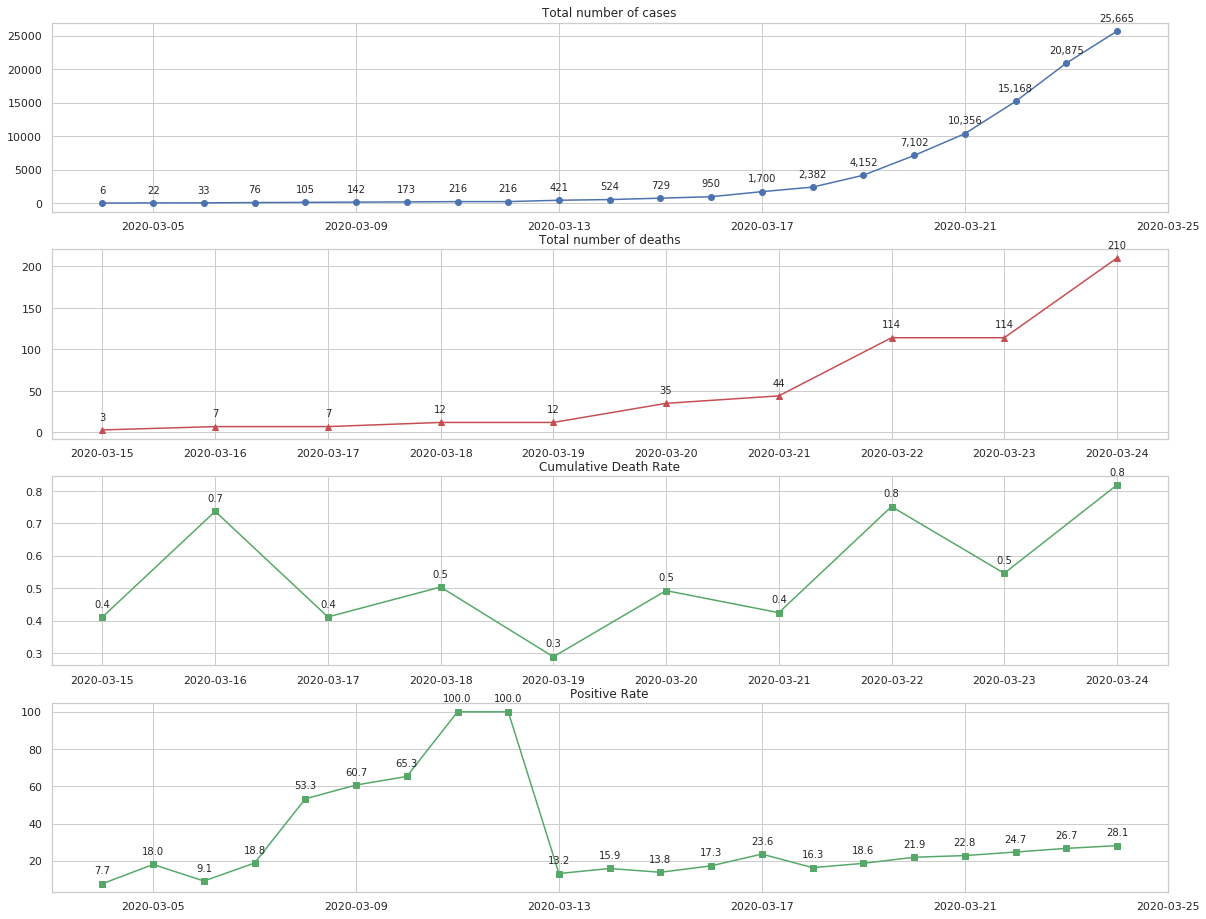

In [18]:
plt.figure(figsize = (20,16))

# plt.gca().title('Italian Cases')

plt.subplot('411')
xs = ny_data.index.values
ys = ny_data['positive']
plt.gca().set_title('Total number of cases')
plt.plot(xs, ys, 'bo-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('412')
plt.gca().set_title('Total number of deaths')
ys = ny_data['death']
plt.plot(xs, ys, 'r^-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('413')
plt.gca().set_title('Cumulative Death Rate')
ys = ny_data['death'] / ny_data['positive'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.subplot('414')
plt.gca().set_title('Positive Rate')
ys = ny_data['positive'] / ny_data['total'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.savefig('ny_overview')
plt.show()